### Nearest Neighbor Traveling Salesman
In this script, I create an agent that uses a nearest neighbor heuristic strategy to solve the traveling salesmen problem. According to both computational and behavioral research, this problem can only be solved in a timely manner using heuristic-based solutions. With the nearest neighbor strategy, an instantiated agent must start and return at a given location. When deciding to move to the next location, they evaluate how far each of the remaining alternatives are from their current location. They choose the closest option and repeat the process until they must return to the starting location. This heuristic has been identified as an incredibly simple solution to real world versions of this problem where agents (e.g., animals) are bound by limited perceptive fields and memory. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
locations_df = pd.read_csv("../arrangements/generated_nn_suboptimal1.csv")

locations_df

,Unnamed: 0,location,x,y
0,0,1,45,-41
1,1,2,43,-46
2,2,3,-16,-60
3,3,4,4,29
4,4,5,41,11
5,5,6,54,54
6,6,7,-48,18
7,7,8,48,-18


Using a specified starting point, navigate to the closest neighbor until all locations are visited. Then return to the start point. Use the distance matrix to determine what is closest.

In [3]:
# create a distance matrix between all positions that can be accessed
def euclid_distance_matrix(df = pd.DataFrame):
    # create empty matrix of necessary size
    n = len(df)
    dist_matrix = np.zeros((n, n), dtype=float)
    
    # prespecify the location coord list
    location_i = []
    location_j = []
    
    # fill matrix by calculating dist between appropriate locations
    for i in range(n):
        for j in range(n):
            location_i = [df.x.iloc[i], df.y.iloc[i]]
            location_j = [df.x.iloc[j], df.y.iloc[j]]
            
            # calculate euclid distance
            dist = np.sqrt(
                np.pow(location_i[0] - location_j[0], 2) + np.pow(location_i[1] - location_j[1], 2)
            )
            
            dist_matrix[i][j] = dist
    
    return dist_matrix
    
dist_matrix = euclid_distance_matrix(locations_df)

In [4]:
# find the value of the individual (route)
def total_distance_individual(individual):
    total_dist = 0
    
    # loop through list of locations and caclulate their distances
    for i in range(0, len(individual)):
        # get location i subtract 1 to access in matrix
        location_1_index = individual[i] - 1
        
        if(i == len(individual) - 1):
            location_2_index = individual[0] - 1
            # route back to starting location 
            total_dist += dist_matrix[location_1_index][individual[0] - 1]
        else:
            location_2_index = individual[i+1] - 1
            # find distance between location and next
            total_dist += dist_matrix[location_1_index][location_2_index]
    
    return total_dist

Find the nearest neighbor that hasn't already been visited. 

In [5]:
# using a given location find the nearest neighbor
def find_nearest_neighbor(
    dist_matrix = np.matrix, location = int, 
    previously_visited = list
    ):
    # create new df with distances along with 
    df = pd.DataFrame({
        'location' : [*range(1, len(locations_df)+1)],
        'distances' : dist_matrix[location-1]
        }, 
        index=[*range(0, len(locations_df))]
    )
    
    # see if this df should be filtered for previously visited locations
    if len(previously_visited) > 0:
        # remove previously visited locations
        df = df[~df.location.isin(previously_visited)]
    
    # sort according to distance
    df = df[df.distances > 0].sort_values('distances')
        
    # select next closest neighbor
    nn = [*df.location][0]
    
    return nn

find_nearest_neighbor(dist_matrix, 1, [7, 6])

2

Link together visits to create the path the nn agent will make through the arrangement.

In [6]:
# using a starting point on the arrangement, determine nn path
def run_nn(start_location = int):
    path = []
    
    path.append(start_location)
    
    for i in range(0, len(locations_df)-1):
        next_stop = find_nearest_neighbor(dist_matrix, path[-1], path)
        
        path.append(next_stop)

    return path
    

##### Run the algorithm

In [7]:
# try one variation from a single starting point
nn_path = run_nn(4)

distance = total_distance_individual(nn_path)

print(nn_path, distance)

[4, 5, 8, 1, 2, 3, 7, 6] 408.574405897884


In [8]:
# try all variations
paths = []
total_distances = []

for location in locations_df.location:
    path = run_nn(location)
    paths.append(path)
    dist = total_distance_individual(path)
    total_distances.append(dist)
    print(path, dist)

    

[1, 2, 8, 5, 4, 7, 3, 6] 471.4680193843336
[2, 1, 8, 5, 4, 7, 3, 6] 471.397738446711
[3, 2, 1, 8, 5, 4, 7, 6] 455.2904119561557
[4, 5, 8, 1, 2, 3, 7, 6] 408.574405897884
[5, 8, 1, 2, 3, 7, 4, 6] 357.334670365188
[6, 5, 8, 1, 2, 3, 7, 4] 357.334670365188
[7, 4, 5, 8, 1, 2, 3, 6] 455.29041195615565
[8, 1, 2, 5, 4, 7, 3, 6] 470.2463342012838


##### Visualize the results

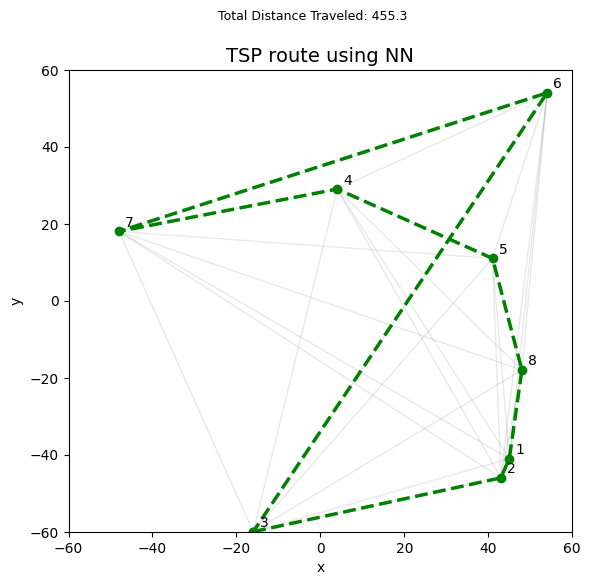

In [12]:
starting_location = 3
focal_path = paths[starting_location-1]
focal_distance = total_distances[starting_location-1]

x_shortest = []
y_shortest = []
for location in focal_path:
    x_value = locations_df['x'].iloc[location - 1]
    y_value = locations_df['y'].iloc[location - 1]
    x_shortest.append(x_value)
    y_shortest.append(y_value)
    
x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

fig, ax = plt.subplots()

for i in range(len(locations_df.x)):
    for j in range(i+1, len(locations_df.x)):
        ax.plot([locations_df.x[i], locations_df.x[j]], [locations_df.y[i], locations_df.y[j]], 'k-', alpha=.09, linewidth = 1)

ax.plot(x_shortest, y_shortest, '--go', linewidth = 2.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])

plt.title(label = "TSP route using NN", fontsize = 14, color = 'k')
plt.suptitle("Total Distance Traveled: "+str(round(focal_distance, 1)), fontsize = 9)

for i, loc in enumerate(focal_path):
    ax.annotate(str(loc), (x_shortest[i] + 1.5, y_shortest[i] + 1.25), fontsize = 10)
    
fig.set_size_inches(6.5, 6)
plt.show()

In [13]:
def plot_nn_path(starting_location = int, nn_dict = dict, locations_df = pd.DataFrame):
    focal_path = nn_dict['paths'][starting_location-1]
    focal_distance = nn_dict['distances'][starting_location-1]

    x_shortest = []
    y_shortest = []
    for location in focal_path:
        x_value = locations_df['x'].iloc[location - 1]
        y_value = locations_df['y'].iloc[location - 1]
        x_shortest.append(x_value)
        y_shortest.append(y_value)
        
    x_shortest.append(x_shortest[0])
    y_shortest.append(y_shortest[0])

    fig, ax = plt.subplots()

    for i in range(len(locations_df.x)):
        for j in range(i+1, len(locations_df.x)):
            ax.plot([locations_df.x[i], locations_df.x[j]], [locations_df.y[i], locations_df.y[j]], 'k-', alpha=.09, linewidth = 1)

    ax.plot(x_shortest, y_shortest, '--go', linewidth = 2.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([-60, 60])
    ax.set_ylim([-60, 60])

    plt.title(label = "TSP route using NN", fontsize = 14, color = 'k')
    plt.suptitle("Total Distance Traveled: "+str(round(focal_distance, 1)), fontsize = 9)

    for i, loc in enumerate(focal_path):
        ax.annotate(str(loc), (x_shortest[i] + 1.5, y_shortest[i] + 1.25), fontsize = 10)
        
    fig.set_size_inches(6.5, 6)
    plt.show()

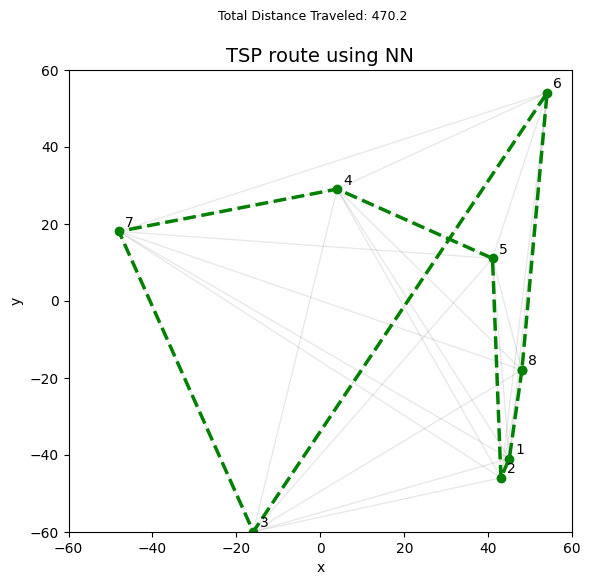

In [21]:
%run -i src/nn_funs.py
nns = run_all_nn(locations_df)

plot_nn_path(8, nns, locations_df)